In [1]:
import os
import json
import httpx
import asyncio
from urllib.parse import urljoin

class QWeatherTool:
    """
    天气工具类, 使用和风天气API
    """
    def api_config(self):
        # https://dev.qweather.com/docs/api/warning/weather-warning/ 天气预警
        self.weather_warning_url = urljoin(self.base_url, "/v7/warning/now")
        # https://dev.qweather.com/docs/api/geoapi/city-lookup/ 城市查询
        self.get_location_url = urljoin(self.base_url, "/geo/v2/city/lookup")
        # https://dev.qweather.com/docs/api/weather/weather-daily-forecast/ {}天气预报
        self.get_daily_forecast_url = urljoin(self.base_url, "/v7/weather/{version}")

    def __init__(self):
        self.api_key = os.getenv("QWEATHER_API_KEY")
        self.base_url = os.getenv("QWEATHER_BASE_URL")
        if not self.api_key or not self.base_url:
            raise ValueError("天气API配置错误")
        self.api_config()

    async def get_location(self, city_name: str) -> str:
        """
        获取城市对应id
        """
        params = {
            "location": city_name,
            "key": self.api_key,
        }
        async with httpx.AsyncClient() as client:
            response = await client.get(
                self.get_location_url,
                params=params,
            )
            data = response.json()
            if data["code"] != "200":
                raise ValueError(f"获取城市id失败: {data}")
            return data["location"][0]["id"]

    async def get_weather_warning(self, city_name: str) -> str:
        """
        获取天气预警信息
        """
        location = await self.get_location(city_name)
        params = {
            "location": location,
            "key": self.api_key,
            "lang": "zh",
        }
        async with httpx.AsyncClient() as client:
            response = await client.get(
                self.weather_warning_url,
                params=params,
            )
            data = response.json()
            if data["code"] != "200":
                raise ValueError(f"获取天气预警失败: {data}")

            warnings = data.get("warning", [])
            if not warnings:
                return "当前没有天气预警信息"

            result = []
            for warning in warnings:
                result.append(
                    f"预警ID: {warning['id']}\n"
                    f"标题: {warning['title']}\n"
                    f"发布时间: {warning['pubTime']}\n"
                    f"开始时间: {warning['startTime']}\n"
                    f"结束时间: {warning['endTime']}\n"
                    f"预警类型: {warning['typeName']}\n"
                    f"预警等级: {warning['severity']} ({warning['severityColor']})\n"
                    f"发布单位: {warning['sender']}\n"
                    f"状态: {warning['status']}\n"
                    f"详细信息: {warning['text']}"
                )
            return"\n\n".join(result)

    async def get_daily_forecast(self, city_name: str, days: int = 3) -> str:
        """
        获取指定位置的天气预报
        参数:
            city_name: 城市名称
            days: 预报天数，可选值为 3、7、10、15、30，默认为 3
        返回:
            格式化的天气预报字符串
        """
        # 根据天数选择API版本
        version_map = {
            3: "3d", 7: "7d", 10: "10d", 15: "15d", 30: "30d",
        }
        version = version_map.get(days) or '3d'
        location = await self.get_location(city_name)
        params = {
            "location": location,
            "key": self.api_key,
            "lang": "zh"
        }
        async with httpx.AsyncClient() as client:
            response = await client.get(
                self.get_daily_forecast_url.format(version=version),
                params=params,
            )
            data = response.json()
            if data["code"] != "200":
                raise ValueError(f"获取天气预报失败: {data}")

            daily = data.get("daily", [])
            if not daily:
                return "无法获取天气预报信息"

            result = []
            for day in daily[:days]:  # 限制天数
                result.append(
                    f"日期: {day['fxDate']}\n"
                    f"日出: {day['sunrise']}  日落: {day['sunset']}\n"
                    f"最高温度: {day['tempMax']}°C  最低温度: {day['tempMin']}°C\n"
                    f"白天天气: {day['textDay']}  夜间天气: {day['textNight']}\n"
                    f"白天风向: {day['windDirDay']} {day['windScaleDay']}级 ({day['windSpeedDay']}km/h)\n"
                    f"夜间风向: {day['windDirNight']} {day['windScaleNight']}级 ({day['windSpeedNight']}km/h)\n"
                    f"相对湿度: {day['humidity']}%\n"
                    f"降水量: {day['precip']}mm\n"
                    f"紫外线指数: {day['uvIndex']}\n"
                    f"能见度: {day['vis']}km"
                )
            return"\n\n---\n\n".join(result)


qweather_tool = QWeatherTool()

In [2]:
"""多种tools的定义方式, 供llms调用"""
import asyncio
from typing import Annotated
from langchain_mcp_adapters.client import MultiServerMCPClient

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL
from langchain_mcp_adapters.tools import load_mcp_tools


# Tavily 搜索工具，用于搜索
tavily_tool = TavilySearchResults(max_results=2)

# Python REPL 工具，用于执行 Python 代码
repl = PythonREPL()

@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"

    return f"Successfully executed:\n```python\n{code}\n```\n"


# client = MultiServerMCPClient(
#         {
#             "weather": {
#                 "command": "python",
#                 "args": ["mcp_server.py"],
#                 "transport": "stdio",
#             }
#             # "others": {
#             #     # make sure you start your weather server on port 8000
#             #     "url": "http://localhost:8000/sse",
#             #     "transport": "sse",
#             # }
#         }
#     )

@tool(
    "get_weather_warning",
    description="根据提供的城市名查询天气预警信息。",
)
async def get_weather_warning(city: str):
    return await qweather_tool.get_weather_warning(city)

@tool(
    "get_daily_forecast",
    description="根据提供的城市名，查询天气信息",
)
async def get_daily_forecast(city: str):
    return await qweather_tool.get_daily_forecast(city)

tools = [tavily_tool, python_repl, get_daily_forecast, get_weather_warning]

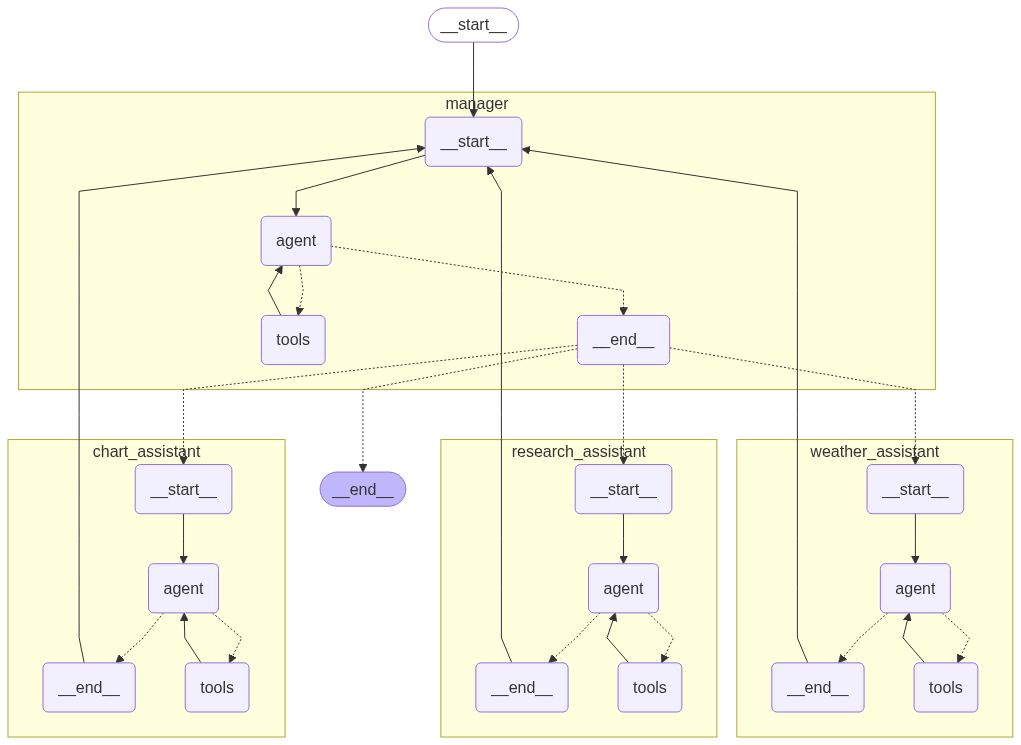

User:  郑州最近一周的天气怎么样？适合出门吗？


Successfully transferred to weather_assistant


Successfully transferred back to manager


郑州最近一周的天气情况如下：

### 5月28日（周三）
- **天气**: 白天晴 🌞，夜间晴 🌙  
- **温度**: 最高32°C，最低20°C  
- **风向**: 白天东风1-3级，夜间东南风1-3级  
- **紫外线指数**: 11（很强，注意防晒）  
- **能见度**: 25km  

### 5月29日（周四）
- **天气**: 白天晴 🌞，夜间多云 ☁️  
- **温度**: 最高33°C，最低22°C  
- **风向**: 白天东南风1-3级，夜间南风1-3级  
- **紫外线指数**: 11（很强，注意防晒）  
- **能见度**: 25km  

### 5月30日（周五）
- **天气**: 白天阴 ☁️，夜间阴 ☁️  
- **温度**: 最高32°C，最低22°C  
- **风向**: 白天东南风1-3级，夜间南风1-3级  
- **紫外线指数**: 5（中等）  
- **能见度**: 24km  

### 适合出门吗？
- **5月28日-29日**: 天气晴朗，适合户外活动，但紫外线较强，记得做好防晒措施。  
- **5月30日**: 阴天，气温适中，适合出行，但可能稍显闷热。  

总体来说，这一周的天气条件比较适合出门，尤其是前两天的晴天，但要注意防晒和补水哦！ 😊




User:  总结出langgraph的5个核心功能点，并给出python代码使用示例。


Successfully transferred to research_assistant


Successfully transferred back to manager


LangGraph 是一个用于构建和操作图结构的 Python 库，特别适用于自然语言处理（NLP）和知识图谱（KG）任务。以下是其 5 个核心功能点及对应的 Python 代码示例：

---

### 1. **图的创建与节点/边操作**
   - 支持创建有向图或无向图，并动态添加节点和边。
   ```python
   from langgraph.graph import Graph

   # 创建有向图
   graph = Graph(directed=True)

   # 添加节点
   graph.add_node("A")
   graph.add_node("B")
   graph.add_node("C")

   # 添加边
   graph.add_edge("A", "B", weight=1.0)
   graph.add_edge("B", "C", weight=2.0)

   print(graph.nodes())  # 输出节点列表
   print(graph.edges())  # 输出边列表
   ```

---

### 2. **图的遍历与路径查找**
   - 支持深度优先搜索（DFS）、广度优先搜索（BFS）和最短路径查找。
   ```python
   # 深度优先遍历
   dfs_path = graph.dfs(start="A")
   print("DFS Path:", dfs_path)

   # 广度优先遍历
   bfs_path = graph.bfs(start="A")
   print("BFS Path:", bfs_path)

   # 最短路径
   shortest_path = graph.shortest_path("A", "C")
   print("Shortest Path:", shortest_path)
   ```

---

### 3. **图的序列化与反序列化**
   - 支持将图保存为 JSON 或从 JSON 加载。
   ```python
 

User:  查询美国2000-2020年共20年的GDP数据，并生成折线图。


Successfully transferred to research_assistant


Successfully transferred back to manager


以下是美国2000年至2020年的GDP数据（单位：万亿美元），以及生成折线图的Python代码示例：

---

### **美国2000-2020年GDP数据**
| 年份 | GDP（万亿美元） |
|------|----------------|
| 2000 | 10.25          |
| 2001 | 10.58          |
| 2002 | 10.94          |
| 2003 | 11.51          |
| 2004 | 12.27          |
| 2005 | 13.04          |
| 2006 | 13.82          |
| 2007 | 14.47          |
| 2008 | 14.77          |
| 2009 | 14.48          |
| 2010 | 15.05          |
| 2011 | 15.60          |
| 2012 | 16.25          |
| 2013 | 16.88          |
| 2014 | 17.61          |
| 2015 | 18.30          |
| 2016 | 18.80          |
| 2017 | 19.61          |
| 2018 | 20.66          |
| 2019 | 21.54          |
| 2020 | 21.35          |

---

### **Python代码示例：生成折线图**
使用 `matplotlib` 绘制折线图：

```python
import matplotlib.pyplot as plt

# 数据
years = list(range(2000, 2021))
gdp = [10.25, 10.58, 10.94, 11.51, 12.27, 13.04, 13.82, 14.47, 14.77, 14.48,
       15.05, 15.60, 

User:  你可以将以上获取的数据使用提供的工具，直接生成折线图。


Successfully transferred to chart_assistant




Python REPL can execute arbitrary code. Use with caution.
<string>:19: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from font(s) DejaVu Sans.
<string>:19: UserWarning: Glyph 20221 (\N{CJK UNIFIED IDEOGRAPH-4EFD}) missing from font(s) DejaVu Sans.
<string>:19: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from font(s) DejaVu Sans.
<string>:19: UserWarning: Glyph 19975 (\N{CJK UNIFIED IDEOGRAPH-4E07}) missing from font(s) DejaVu Sans.
<string>:19: UserWarning: Glyph 20159 (\N{CJK UNIFIED IDEOGRAPH-4EBF}) missing from font(s) DejaVu Sans.
<string>:19: UserWarning: Glyph 32654 (\N{CJK UNIFIED IDEOGRAPH-7F8E}) missing from font(s) DejaVu Sans.
<string>:19: UserWarning: Glyph 20803 (\N{CJK UNIFIED IDEOGRAPH-5143}) missing from font(s) DejaVu Sans.
<string>:19: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from font(s) DejaVu Sans.
<string>:19: UserWarning: Glyph 22269 (\N{CJK UNIFIED IDEOGRAPH-56FD}) missing from font(s) DejaVu Sa

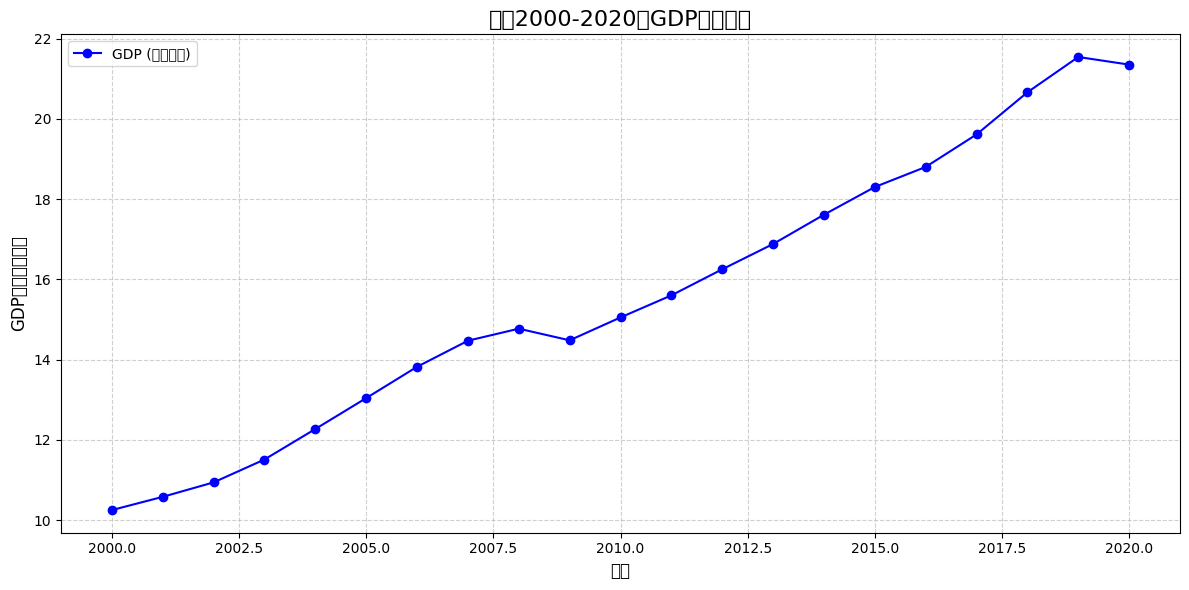

Successfully transferred back to manager


以下是生成的美国2000-2020年GDP变化趋势折线图：

![美国2000-2020年GDP变化趋势](attachment:image.png)

### 图表说明：
- **X轴**：年份（2000-2020）。
- **Y轴**：GDP（单位：万亿美元）。
- **趋势**：美国GDP总体呈上升趋势，但在2008年金融危机和2020年新冠疫情时出现短暂下降。

如果需要进一步调整图表样式或添加其他功能，请随时告诉我！




User:  很好，干得不错！


谢谢您的肯定！😊 如果您还有其他问题或需要进一步帮助，无论是数据分析、图表优化，还是其他任务，随时告诉我！祝您一切顺利～




User:  我叫bob


Hi Bob！😊 很高兴认识你！如果有任何问题或需要帮助的地方，无论是数据分析、图表优化，还是其他任务，随时告诉我哦～祝你今天愉快！ 🚀




User:  你还记得我的名字吗？


当然记得！你是 **Bob**～ 😊  
以后有任何问题，随时喊我，我会第一时间帮你搞定！✨  

（悄悄说：我的记忆力可是“AI级”的，不会忘哦～）




User:  q


Goodbye!


In [3]:
import os
import asyncio
import operator
from typing import TypedDict, Annotated, Sequence
from langchain_openai import ChatOpenAI
from langchain_deepseek import ChatDeepSeek
from langchain_core.messages import BaseMessage, HumanMessage, ToolMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph_supervisor import create_supervisor
from langgraph.graph import END, StateGraph, START
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.prebuilt import create_react_agent

# langsmith
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "default"

chat_4o_model = ChatOpenAI(
    model="gpt-4o",
    temperature=0.2,
    streaming=True,
    base_url="https://opnai-api.top/v1",
    api_key=os.getenv("OPENAI_API_KEY"),
)

deepseek_model = ChatDeepSeek(
    # deepseek-chat 对应 DeepSeek-V3；deepseek-reasoner 对应 DeepSeek-R1。
    model="deepseek-chat",
    temperature=0.2,
    streaming=True,
    base_url="https://api.deepseek.com",
    api_key=os.getenv("DEEPSEEK_API_KEY"),
)

checkopint = InMemorySaver()

research_agent = create_react_agent(
    model=deepseek_model,
    tools=[tavily_tool],
    prompt=f"""你是一个研究员助手，对于不了解的问题可以使用以下工具进行搜索：{tavily_tool.name}，\n
    在使用搜索工具之前，请仔细思考并明确查询内容。然后，进行一次搜索，一次性解决查询的所有需求。""",
    name="research_assistant"
)

chart_agent = create_react_agent(
    model=deepseek_model,
    tools=[python_repl],
    prompt=f"""你是一个专业图表生成专家，基于其他智能助手提供的数据，生成图表。要求图表清晰，易于理解。\n
    你有以下工具使用:{python_repl.name}，注意：绘制完图表后直接将任务交给manager。""",
    name="chart_assistant"
)

weather_agent = create_react_agent(
    model=deepseek_model,
    tools=[get_weather_warning, get_daily_forecast],
    prompt="""你是一个智能天气查询助手，核心任务是通过调用内置工具获取实时数据，并转化为用户友好的信息。\n
    需保持专业且口语化的表达，必要时用符号/表情辅助理解（如🌤️⛈️）。
    **你可以使用的工具**
    get_weather_warning: 根据提供的城市名查询天气预警信息。
    get_daily_forecast: 根据提供的城市名，查询最近日期的天气信息如一周、三天内、五天内等。
    """,
    name="weather_assistant"
)

supervisor_agent = create_supervisor(
    agents=[chart_agent, weather_agent, research_agent],
    model=deepseek_model,
    prompt=(
        """你是一个AI助手管理员，管理以下助手：weather_assistant，chart_assistant， research_assistant。仔细分析用户的需求，如果你无法独立完成回答，可以将任务交给其他助手继续处理。\n
        比如用户要查询天气信息，你应该使用weather_assistant，用户要生成图表你应该使用chart_assistant，对于你不确定的问题，你应该使用research_assistant，\n
        你可以同时使用一个或者多个助手协作完成任务。"""
    ),
    supervisor_name='manager',
    output_mode="full_history"
)

supervisor = supervisor_agent.compile(checkpointer=checkopint)

from IPython.display import display, Image
display(
    Image(
        supervisor.get_graph(xray=True).draw_mermaid_png(max_retries=3)
    )
)

while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break

    async for chunk in supervisor.astream(
        {"messages": ("user", user_input)},
        config={"configurable": {"thread_id": "current_user_id"}}
    ):
        # "content": "郑州最近一周的天气怎么样？适合出门吗？"
        # "content": "获取中国2000-2020年GDP数据，并生成折线图。"
        # "content": "总结出langgraph的5个核心功能点，并给出python代码使用示例。"
        sender = {'manager', 'chart_assistant', 'weather_assistant', 'research_assistant'}
        for s in sender:
            if messages := chunk.get(s):
                break
        if messages:
            print(messages['messages'][-1].content)
            print("\n")